### 04_model_evaluation_Retrained:
    Notebook to load the re-trained model on LFW dataset and evaluate the metrics on the test dataset

In [1]:
import sys
sys.path.append("../")

import random
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

from backbone.dataset import Face_Dataset

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

Using TensorFlow backend.


In [2]:
batch_size = 16

In [15]:
face_data_train = Face_Dataset(root_dir= "../lfw/", file_root = "../files/", 
                               train=True)

train_dataloader = DataLoader(face_data_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

face_data_test = Face_Dataset(root_dir= "../lfw/", 
                              file_root = "../files/", 
                              test=True)

test_dataloader = DataLoader(face_data_test,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

In [16]:
from backbone.networks.inception_resnet_v1 import InceptionResnetV1

### Load the trained model weights

In [17]:
model = InceptionResnetV1(pretrained='vggface2')
checkpoint = torch.load("../experiments/best_inception_resnet_V1_pretrained.pth")
model.load_state_dict(checkpoint)
model = model.cuda()

In [23]:
labels = []
cosine_similarity = []
eucledian_distances = []

for data in test_dataloader:
    
    model.eval()
    with torch.no_grad():
        
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))
        
        embedding1 = model(img1)
        embedding2 = model(img2)
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1,embedding2).cpu().numpy())
        
        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim = True)
        eucledian_distances += list(euclidean_distance.cpu().numpy()[0])   

(array([  6.,  10.,  19.,  28.,  22.,  36.,  33.,  44.,  64., 238.]),
 array([0.07347541, 0.16612788, 0.25878033, 0.3514328 , 0.44408524,
        0.5367377 , 0.6293902 , 0.7220426 , 0.81469506, 0.90734756,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

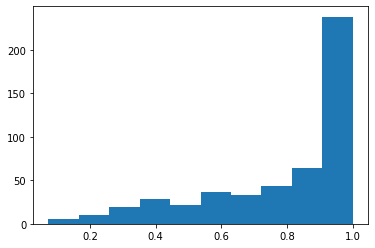

In [33]:
plt.hist(cosine_similarity)

(array([132.,  45.,  52.,  48.,  45.,  42.,  44.,  43.,  34.,  15.]),
 array([2.2627417e-05, 1.3614713e-01, 2.7227163e-01, 4.0839615e-01,
        5.4452068e-01, 6.8064517e-01, 8.1676966e-01, 9.5289415e-01,
        1.0890187e+00, 1.2251432e+00, 1.3612677e+00], dtype=float32),
 <a list of 10 Patch objects>)

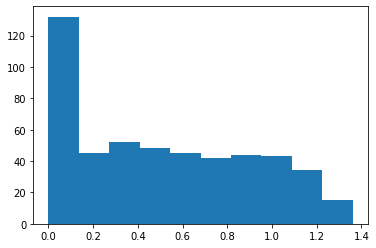

In [34]:
plt.hist(eucledian_distances)

### Determining Threshold for cosine similarity

In [40]:
thresholds = list(np.arange(0.3, 1.0, 0.01))

f1_scores = [f1_score(labels, cosine_similarity > t) for t in thresholds]
acc_scores = [accuracy_score(labels, cosine_similarity > t) for t in thresholds] 


Text(0, 0.5, 'F1 Score')

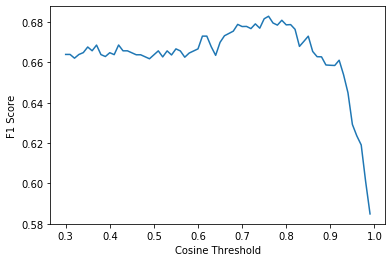

In [41]:
plt.plot(thresholds,f1_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("F1 Score")

In [38]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

In [39]:
print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))

At threshold : 0.76, we get a maximum of f1 score : 0.682842287694974 
